In [1]:
#librerias Keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.layers import LSTM, GRU
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from utils.multi_gpu import make_parallel
from dataset.dataset import leer
from keras.utils.np_utils import to_categorical

### Cargar Datos
___

In [3]:
%%time
URL='data/'
Xtr,Ytr,Xt,Yt,Xv,Yv = leer(URL)
#Datos de entrenamiento
X_train = Xtr.reshape((Xtr.shape[0],32,32,3))
X_train = X_train.transpose([0, 3, 2, 1]) 
Y_train = to_categorical(Ytr, 10)
#Datos de Test
X_test  = Xt.reshape((Xt.shape[0],32,32,3))
X_test  = X_test.transpose([0, 3, 2, 1])
Y_test  = to_categorical(Yt, 10)
#Datos de Validación
X_val   = Xv.reshape((Xv.shape[0],32,32,3))
X_val   = X_val.transpose([0, 3, 2, 1])
Y_val   = to_categorical(Yv, 10)

X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_val   = X_val.astype('float32')

CPU times: user 836 ms, sys: 581 ms, total: 1.42 s
Wall time: 1.42 s


In [4]:
print (X_train.shape)
print (X_test.shape)
print (Y_train.shape)
print (Y_test.shape)

(50000, 3, 32, 32)
(10000, 3, 32, 32)
(50000, 10)
(10000, 10)


Se usará un dataset de entrenamiento de tamaño 4000, esto con el fin demás de asegurar el paralelismo al entrenar y evaluar la red.


In [25]:
print (X_val.shape)
print (Y_val.shape)

(4000, 3, 32, 32)
(4000, 10)


In [5]:
_size, n_channels, n_rows, n_cols = X_train.shape
n_classes = 10

Se carga el mismo modelo usado en la parte (b), que podemos ver su esquema a continuación:


In [6]:
model = Sequential()
model.add(Convolution2D(64, (3, 3), padding='same', input_shape=(n_channels, n_rows, n_cols)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(n_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 32, 32)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 64, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 16, 16)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 64, 16, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 8, 8)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

Objetivo
-----

**(D)** Entrene la CNN definida en (b) utilizando RMSProp durante 25 epochs. Elija la funcion de perdida más apropiada para este problema. Construya finalmente un grafico que muestre los errores de entrenamiento, validacion y pruebas como funcion del numero de “epochs”.

In [7]:
from keras.optimizers import SGD, rmsprop
opt = rmsprop(lr=0.001, decay=1e-6)
epochs = 25
batch_size= 400

Con el paso que viene a continuación, logramos que todas las operaciones sobre el modelo pasen de ejecutarse en una GPU, a un esquema paralelo multi-GPU. Esto se verá reflejado en los tiempos de fit, registrados en los notebook.  

In [ ]:
model = make_parallel(model, 8)

In [9]:
#Se usará la función categorical_crossentropy dado que esperamos salidas mutuamente excluyentes por cada categoría
model.compile(loss='categorical_crossentropy', optimizer=opt,  metrics=['accuracy'])

In [10]:
%%time
history_categorical_crossentropy = model.fit(X_train, Y_train,batch_size=batch_size,epochs=epochs,verbose=0,
          validation_data=(X_val, Y_val),shuffle=True)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


CPU times: user 8min 16s, sys: 3min 14s, total: 11min 30s
Wall time: 2min 32s


In [13]:
# Se usará la función mean_squared_error con el mismo optimizador rmsprop(lr=0.001, decay=1e-6), 
#para comparar los resultados
model.compile(loss='mean_squared_error', optimizer=opt,  metrics=['accuracy'])

In [14]:
%%time
history_mean_squared_error = model.fit(X_train, Y_train,batch_size=batch_size,epochs=epochs,verbose=0,
          validation_data=(X_val, Y_val),shuffle=True)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


CPU times: user 8min 25s, sys: 3min 18s, total: 11min 44s
Wall time: 2min 27s


Podemos ver también el resultado en tiempo de usar la paralelización de datos en multi-GPU, con un tiempo total de **11min 44s**


### Comentarios
---

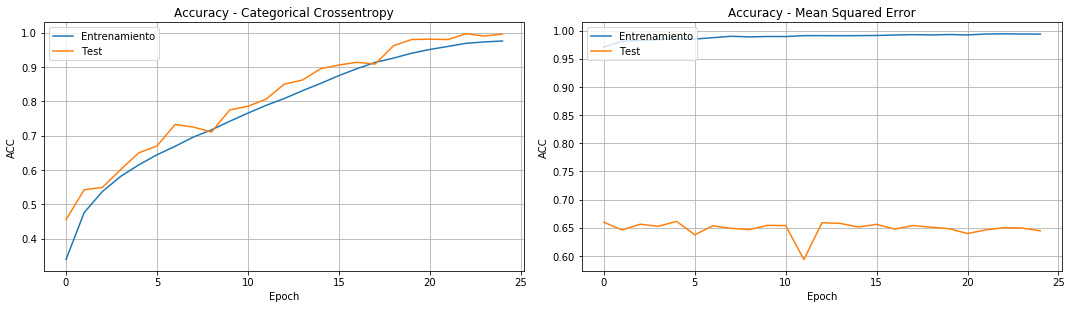

In [24]:
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)

plt.plot(history_categorical_crossentropy.history['acc'])  
plt.plot(history_categorical_crossentropy.history['val_acc'])  
plt.title('Accuracy - Categorical Crossentropy')  
plt.ylabel('ACC')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(history_mean_squared_error.history['acc'])  
plt.plot(history_mean_squared_error.history['val_acc'])  
plt.title('Accuracy - Mean Squared Error')  
plt.ylabel('ACC')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

Claramente podemos ver que la curva de aprendizaje con categorical crossentropy es muy superior a Mean Squared Error, pero esto ya lo habíamos comentado en el punto anterior en términos que en el problema esperamos salidas mutuamente excluyentes por cada categoría. Lo que si es interesante es el efecto en el accuracy del modelo, pues con el optimizador rmsprop  pasamos de un 49.95% a un 66.11% lo que evidencia la potencia de rmsprop

In [12]:
scores = model.evaluate(X_test, Y_test)
print("")
print("Accuracy del modelo con categorical_crossentropy: %.2f%%" % (scores[1]*100))

 9920/10000 [============================>.] - ETA: 0s

In [22]:
#%%time
scores = model.evaluate(X_test, Y_test)
print("")
print("Accuracy del modelo con Mean Squared Error: %.2f%%" % (scores[1]*100))

 9952/10000 [============================>.] - ETA: 0s